In [19]:
%pylab inline
import collections
import math
import torch
import os, tarfile, json
import time, datetime
from io import StringIO
import numpy as np
import sagemaker
from sagemaker.pytorch import estimator, PyTorchModel, PyTorchPredictor, PyTorch
from sagemaker.utils import name_from_base
import boto3
from types import SimpleNamespace
from PIL import Image
import base64

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'privisaa-bucket-virginia'#sagemaker_session.default_bucket() # can replace with your own S3 bucket 'privisaa-bucket-virginia' # 
prefix = 'detectron2'
runtime_client = boto3.client('runtime.sagemaker')

Populating the interactive namespace from numpy and matplotlib


In [2]:
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Need to decide how to implement predictor.py 
Vadim's method uses the input_fn and model_fn approach, the BERT NGC version builds its own flask app, you should try Vadim's way first 

In [28]:
%%sh

# The name of our algorithm
algorithm_name=detectron2-train

chmod +x train
chmod +x serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

# some kind of security auth issue with pushing this to ecr, not authorized to perform ecr:InitiateLayerUpload
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  689.6MB
Step 1/9 : FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.4.0-gpu-py36-cu101-ubuntu16.04
1.4.0-gpu-py36-cu101-ubuntu16.04: Pulling from pytorch-inference
976a760c94fc: Pulling fs layer
c58992f3c37b: Pulling fs layer
0ca0e5e7f12e: Pulling fs layer
f2a274cc00ca: Pulling fs layer
708a53113e13: Pulling fs layer
6295ebf8c067: Pulling fs layer
378a3c4b6a48: Pulling fs layer
39653001dda5: Pulling fs layer
1b7b24954ce9: Pulling fs layer
761094c83145: Pulling fs layer
74c98e4c5072: Pulling fs layer
5c02da75f427: Pulling fs layer
aa5ef1799203: Pulling fs layer
f2a274cc00ca: Waiting
76d930daf6c1: Pulling fs layer
708a53113e13: Waiting
af93311ca135: Pulling fs layer
6295ebf8c067: Waiting
378a3c4b6a48: Waiting
4afd0ff564bb: Pulling fs layer
2d4e6fd722c5: Pulling fs layer
39653001dda5: Waiting
0e2476b430ea: Pulling fs layer
b2b47e84ab83: Pulling fs layer
1b7b24954ce9: Waiting
db69de468f1e: Pulling fs layer
7832a59

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

failed to register layer: Error processing tar file(exit status 1): write /opt/conda/lib/libcufft.so.10.1.1.243: no space left on device


In [29]:
!ls

Filesystem     1K-blocks      Used Available Use% Mounted on
devtmpfs        31426660        72  31426588   1% /dev
tmpfs           31437356         0  31437356   0% /dev/shm
/dev/xvda1     113400460 105225360   8074852  93% /
/dev/xvdf      825629592  11794948 780201744   2% /home/ec2-user/SageMaker


In [2]:
# save the model as a tarball
with tarfile.open('d2.tar.gz', 'w:gz') as f:
    f.add('/home/ec2-user/SageMaker/model_final.pth')

In [17]:
#local deploy
container_serving = "detectron2-train" # your container name
tag = "latest" # you can have several version of container available
#image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag)

model = PyTorchModel(
                     name = "local-1",
                     model_data=model_data,
                     role=role,
                     entry_point="predict_coco.py", source_dir="/home/ec2-user/SageMaker/detectron2_train",
                     framework_version="1.4", py_version="3.6",
                     image='209419068016.dkr.ecr.us-east-1.amazonaws.com/detectron2-train')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:
predictor = model.deploy(
                         instance_type = 'local_gpu',
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}-local-1", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=False
                         )

Attaching to tmpdv6ae4d7_algo-1-f6lb3_1
algo-1-f6lb3_1  | nginx: /opt/conda/lib/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libgd.so.3)
algo-1-f6lb3_1  | 2020/07/15 18:33:24 [crit] 19#19: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
algo-1-f6lb3_1  | 172.18.0.1 - - [15/Jul/2020:18:33:24 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
algo-1-f6lb3_1  | 2020/07/15 18:33:29 [crit] 19#19: *3 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
algo-1-f6lb3_1  | 172.18.0.1 - - [15/Jul/2020:18:33:29 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
algo-1-f6lb3_1  | Processing /opt/ml

KeyboardInterrupt: 

Gracefully stopping... (press Ctrl+C again to force)


In [5]:
# upload model data to S3
model_data = sagemaker_session.upload_data(path='d2.tar.gz',
                                           bucket=bucket,
                                           key_prefix =os.path.join(prefix, 'model'))

# instantiate model
torch_model = PyTorchModel(model_data=model_data,
                           role=role,
                           source_dir='detectron2_train', # need to specify a directory here 
                           image='209419068016.dkr.ecr.us-east-1.amazonaws.com/detectron2-train',
                          entry_point='predict_coco.py',
                          framework_version='1.4.0')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [8]:
# deploy endpoint, this part may take a bit
endpoint_name = f'd2-endpoint-{datetime.datetime.fromtimestamp(time.time()).strftime("%c").replace(" ","-").replace(":","-")}'
d2_end = torch_model.deploy(instance_type='ml.g4dn.2xlarge', initial_instance_count=1, 
                              endpoint_name=endpoint_name)

# need to have a serve command in the exec path if specifying an image 
# try torchserve here?

Using already existing model: detectron2-train-2020-07-15-17-52-03-403


---------------------------------*

UnexpectedStatusException: Error hosting endpoint d2-endpoint-Wed-Jul-15-17-52-44-2020: Failed. Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

In [29]:
img.size

(704, 396)

In [31]:
img = Image.open('/home/ec2-user/SageMaker/nfl-data/nfl-frames/nfl-video-frame01878.png')
img = img.resize((256,256))
payload = {}
payload['img'] = np.array(img).tolist() #.tobytes()
endpoint_name = 'd2-endpoint-Wed-Jul-15-13-57-29-2020'

# try:
response = d2_end.predict(json.dumps(payload), initial_args={'ContentType':'application/json'}) 
# except:
#     print('using invoke_endpoint directly')
#     response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
#                                            ContentType='application/json',
#                                            Body=json.dumps(payload))
#     response = eval(response['Body'].read().decode('utf-8'))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/d2-endpoint-Wed-Jul-15-14-34-23-2020 in account 209419068016 for more information.

In [ ]:
payload = np.concatenate([np.expand_dims(input_ids, axis=0), np.expand_dims(segment_ids, axis=0), np.expand_dims(input_mask, axis=0)])
try:
    response = d2_end.predict(payload.tobytes(), initial_args={'ContentType':'application/x-npy'}) 
except:
    print('using invoke_endpoint directly')
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                           ContentType='application/x-npy',
                                           Body=payload.tobytes())
    response = eval(response['Body'].read().decode('utf-8'))

# print result
print(f'{question} : {answer[0]["text"]}')

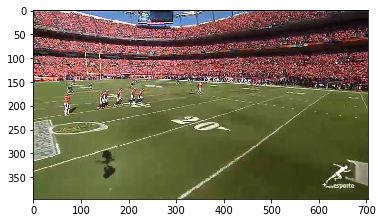

In [17]:
img = Image.open('/home/ec2-user/SageMaker/nfl-data/nfl-frames/nfl-video-frame01878.png')
payload = {}
payload['img'] = np.array(img).tolist() #.tobytes()
pay = json.dumps(payload)

payl = json.loads(pay)
img = np.array(payl['img'])
imshow(img)

In [23]:
import flask

In [25]:
!pip install ezsmdeploy

     |████████████████████████████████| 304 kB 11.6 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.58.2-py2.py3-none-any.whl size=400341 sha256=9469eb212e53b1c120704e890791601e5015defdd8bb80a26d98cd7b40cafe9e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/08/75/84/62b3bde8befd85b487082ff95834d0357efbd5ae73408b2ed7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 0.1.4
    Uninstalling smdebug-rulesconfig-0.1.4:
      Successfully uninstalled smdebug-rulesconfig-0.1.4
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 1.67.1.post0
    Uninstalling sagemaker-1.67.1.post0:
      Successfully uninstalled sagemaker-1.67.1.post0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
ez = ezsmdeploy.Deploy(model = [modelpath], #loading pretrained MNIST model
                  script = 'modelscript_pytorch.py',
                  requirements = ['numpy','torch','joblib'], #or pass in the path to requirements.txt
                  instance_type = 'local',
                  wait = True)